<a href="https://colab.research.google.com/github/LiterallyTheOne/deep_learning_class/blob/main/notebooks/session_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Session_8: Generative AI, LLM, Gemini, Multi-modal prompting

# Generative AI

Genernerative AI is a field in deep learning that focuceses on generating new data (text, image, audio, ...).
For example:
* ChatGPT: Text generation
* DALL-E: Image generation
* Wavenet: Audio generation

## Transformers

Transfromer is a type of neural network architecture which at first introduced in a paper called `Attention is all you need` by Vaswani. 
First porpuse of that was for the translation task.
The two main advantages of this architecture are:
* Can remember the past dependencies
* Can be trained parallelly
After that it has been widely used for natural language processing tasks.

## LLM

With the help of transformers, large language models have been created.
They can generate content pretty similar to human writing.
For example:
* ChatGPT
* Gemini
* Meta AI
* Llama

## Gemini

Gemini is a multi-modal model presented by `Google`.
It can take a prompt, image, audio and even a viedo
and generate a response in multiple formats (text, image, audio, video).

We are going to use that to classify one batch of our images.

## Create a Gemini API token

To create an API token, we can use this link: [AI Studio](https://aistudio.google.com/app/apikey)

## Setup

In [1]:
try:
    import google.colab

    %pip install -U -q "google-generativeai>=0.8.3"
    IN_COLAB = True
except:
    IN_COLAB = False


## Imports

In [3]:
import google.generativeai as genai
from google.api_core import retry
import kagglehub

from pathlib import Path

import keras
import numpy as np
from matplotlib import pyplot as plt

from PIL import Image

import enum

/Users/ramin/miniconda3/envs/tf_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
if IN_COLAB:
    from google.colab import userdata

    api_key = userdata.get("GOOGLE_API_KEY")
else:
    api_key = Path("../api_keys/google_api_key").open().read()

genai.configure(api_key=api_key)

## Choose a model

In [5]:
for model in genai.list_models():
    print(model.name)

models/chat-bison-001
models/text-bison-001
models/embedding-gecko-001
models/gemini-1.0-pro-latest
models/gemini-1.0-pro
models/gemini-pro
models/gemini-1.0-pro-001
models/gemini-1.0-pro-vision-latest
models/gemini-pro-vision
models/gemini-1.5-pro-latest
models/gemini-1.5-pro-001
models/gemini-1.5-pro-002
models/gemini-1.5-pro
models/gemini-1.5-pro-exp-0801
models/gemini-1.5-pro-exp-0827
models/gemini-1.5-flash-latest
models/gemini-1.5-flash-001
models/gemini-1.5-flash-001-tuning
models/gemini-1.5-flash
models/gemini-1.5-flash-exp-0827
models/gemini-1.5-flash-002
models/gemini-1.5-flash-8b
models/gemini-1.5-flash-8b-001
models/gemini-1.5-flash-8b-latest
models/gemini-1.5-flash-8b-exp-0827
models/gemini-1.5-flash-8b-exp-0924
models/gemini-2.0-flash-exp
models/gemini-exp-1206
models/gemini-exp-1121
models/gemini-exp-1114
models/learnlm-1.5-pro-experimental
models/embedding-001
models/text-embedding-004
models/aqa


In [6]:
retry_policy = {"retry": retry.Retry(predicate=retry.if_transient_error)}

model = genai.GenerativeModel("gemini-1.5-flash-latest")

## Get data

In [7]:
path = Path(kagglehub.dataset_download("balabaskar/tom-and-jerry-image-classification"))

data_path = path / "tom_and_jerry/tom_and_jerry"

## Load data

In [8]:
BATCHSIZE = 12

all_train_data, test_data = keras.utils.image_dataset_from_directory(
    data_path,
    seed=10,
    validation_split=0.2,
    subset="both",
    batch_size=BATCHSIZE,
    image_size=(80, 190),
    shuffle=True,
)

one_batch_of_test_data = test_data.take(1)

images, labels = next(iter(one_batch_of_test_data))

Found 5478 files belonging to 4 classes.
Using 4383 files for training.
Using 1095 files for validation.


2024-12-13 18:18:02.140846: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-12-13 18:18:02.140896: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-12-13 18:18:02.140908: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-12-13 18:18:02.141118: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-13 18:18:02.141144: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


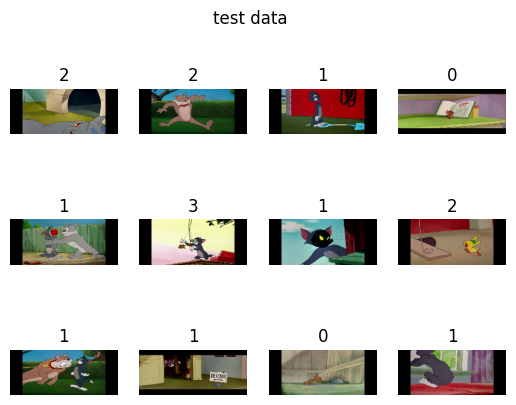

In [9]:
fig, axes = plt.subplots(3, 4)

fig.suptitle("test data")

axes_ravel = axes.ravel()

for i, (image, label) in enumerate(zip(images, labels)):
    axes_ravel[i].imshow(image.numpy().astype("uint8"))
    axes_ravel[i].set_axis_off()
    axes_ravel[i].set_title(f"{label}")

## Multi-modal promptmpting

In [11]:
model = genai.GenerativeModel("gemini-1.5-flash-latest")

prompt = [
    "Is there a tree in this image?",
    Image.fromarray(images[1].numpy().astype("uint8")),
]

response = model.generate_content(prompt, request_options=retry_policy)
print(response.text)

Yes, there is a tree in the upper left corner of the image.  It's partially visible behind the dog.



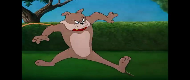

In [10]:
Image.fromarray(images[1].numpy().astype("uint8"))

## Classify an image

In [12]:
prompt = [
    """This image belongs to a cartoon called Tom and Jerry, classify this image as TOM, JERRY, NONE or BOTH.
TOM: when only tom is in the image
Jerry: when only jerry is in the image
NONE: when neither tom nor jerry is in the image
BOTH: when both tom and jerry are in the image
Sentiment: """,
    Image.fromarray(images[1].numpy().astype("uint8")),
]

response = model.generate_content(prompt)
print(response.text)

NONE

The image shows a bulldog, which is not Tom or Jerry.  Therefore, the correct classification is NONE.



## Use Enum

In [13]:
class Sentiment(enum.Enum):
    TOM = "tom"
    JERRY = "jerry"
    NONE = "none"
    BOTH = "both"


model = genai.GenerativeModel(
    "gemini-1.5-flash-latest",
    generation_config=genai.GenerationConfig(
        response_mime_type="text/x.enum", response_schema=Sentiment
    ),
)

prompt = [
    """This image blongs to a cartoon called Tom and Jerry, classify this image as TOM, JERRY, NONE or BOTH.
TOM: when only tom is in the image
Jerry: when only jerry is in the image
NONE: when neither tom nor jerry is in the image
BOTH: when both tom and jerry are in the image
Sentiment: """,
    Image.fromarray(images[2].numpy().astype("uint8")),
]

response = model.generate_content(prompt)
print(response.text)

tom


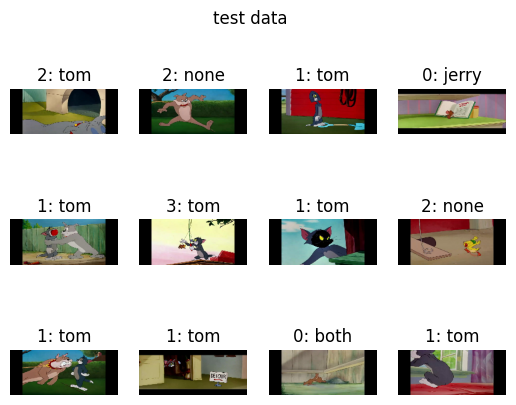

In [14]:
fig, axes = plt.subplots(3, 4)

fig.suptitle("test data")

axes_ravel = axes.ravel()

for i, (image, label) in enumerate(zip(images, labels)):
    axes_ravel[i].imshow(image.numpy().astype("uint8"))
    axes_ravel[i].set_axis_off()
    prompt[1] = Image.fromarray(image.numpy().astype("uint8"))
    response = model.generate_content(prompt)
    axes_ravel[i].set_title(f"{label}: {response.text}")

In [15]:
model = genai.GenerativeModel("gemini-1.5-flash-latest")

prompt = [
    "What is this? Please describe it in detail. it is an image of a cartoon called Tom And Jerry",
    Image.fromarray(images[0].numpy().astype("uint8")),
]

response = model.generate_content(prompt, request_options=retry_policy)
print(response.text)

That's a still image from the classic cartoon series *Tom and Jerry*.

The image shows Tom the cat lying on the ground, seemingly injured or exhausted.  He's mostly gray, and we can see parts of his body including his head, which is turned slightly to the side.  There are some red marks on his face, possibly suggesting wounds or scratches. His expression seems to indicate pain or defeat.

The background is simple: a muted greenish-yellow patch of ground in front of a pale grayish-tan structure that resembles a wall or part of a building with a dark, arched opening that looks like a tunnel or a cave. There are faint dashed lines suggesting a dividing line between the ground and the structure.  The overall style is consistent with the classic *Tom and Jerry* animation.  The colors are somewhat muted and the style is not hyper-realistic.



In [16]:
model = genai.GenerativeModel("gemini-1.5-flash-latest")

prompt = [
    "What is this? Please describe it in detail.",
    Image.fromarray(images[-2].numpy().astype("uint8")),
]

response = model.generate_content(prompt, request_options=retry_policy)
print(response.text)

That's a still image from a Tom and Jerry cartoon.

Specifically, it appears to be a scene where Tom the cat is trying to catch Jerry the mouse.  Jerry is hiding under a pile of something dark-colored (possibly dirt or debris) near a wooden fence.  Tom, a brown cat, is crouched low to the ground, seemingly trying to reach Jerry from under the fence.  A portion of what looks like a wooden rake or similar garden tool rests against the fence.  The setting is outdoors, on grass.  The style is consistent with the classic Hanna-Barbera animation style of Tom and Jerry.

